# Assignment 2 2AMM10 2023-2024

## Group: [Fill in your group name]
### Member 1: [Fill in your name]
### Member 2: [Fill in your name]
### Member 3: [Fill in your name]

We need to install some specific libraries. The cell below installs torch_geometric for torch 2.6.0+cu124. In case the current version of torch is different, check [here](https://pytorch-geometric.readthedocs.io/en/latest/install/installation.html) to see which versions (of both libraries) you should install. You might also need to install an old version of torch from [here](https://pytorch.org/get-started/previous-versions/)

**Note:** Do not install pyg_lib from the optional dependencies

In [1]:
!pip show torch

Name: torch
Version: 2.6.0+cu124
Summary: Tensors and Dynamic neural networks in Python with strong GPU acceleration
Home-page: https://pytorch.org/
Author: PyTorch Team
Author-email: packages@pytorch.org
License: BSD-3-Clause
Location: /usr/local/lib/python3.11/dist-packages
Requires: filelock, fsspec, jinja2, networkx, nvidia-cublas-cu12, nvidia-cuda-cupti-cu12, nvidia-cuda-nvrtc-cu12, nvidia-cuda-runtime-cu12, nvidia-cudnn-cu12, nvidia-cufft-cu12, nvidia-curand-cu12, nvidia-cusolver-cu12, nvidia-cusparse-cu12, nvidia-cusparselt-cu12, nvidia-nccl-cu12, nvidia-nvjitlink-cu12, nvidia-nvtx-cu12, sympy, triton, typing-extensions
Required-by: accelerate, fastai, peft, sentence-transformers, timm, torchaudio, torchdata, torchvision


In [ ]:
# if issue with torch-scatter
!pip uninstall torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric -y

In [2]:
!pip install rdkit
!pip install torch_geometric
!pip install torch_scatter torch_sparse torch_cluster torch_spline_conv -f https://data.pyg.org/whl/torch-2.6.0+cu124.html

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.9/34.9 MB 40.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 24.4 MB/s eta 0:00:00
Looking in links: https://data.pyg.org/whl/torch-2.6.0+cu124.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 76.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 99.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 57.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 45.0 MB/s eta 0:00:00


In [3]:
import pickle
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv, global_mean_pool
import numpy as np
from collections import Counter
from rdkit import Chem
from rdkit.Chem import Draw, AllChem
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*')
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm

In [ ]:
## For colab - Zoe drive
from google.colab import drive
drive.mount('/content/drive')
dataset_dir = "/content/drive/MyDrive/ColabNotebooks/ass2/ass2_data"

In [5]:
## For colab - Win drive
# from google.colab import drive
# drive.mount('/content/drive')
dataset_dir = "/content/ass2_data"

In [ ]:
# For Jupyter Lab
dataset_dir = "ass2_data"

In [6]:
pos_data_path = os.path.join(dataset_dir, "pos_data.pkl")
type_data_path = os.path.join(dataset_dir, "type_data.pkl")
smiles_data_path = os.path.join(dataset_dir, "smiles.pkl")
data_split_path = os.path.join(dataset_dir, "data_split.npz")
formation_energy_path = os.path.join(dataset_dir, "formation_energy.npz")
with open(pos_data_path, 'rb') as f:
    pos_data = pickle.load(f)

with open(type_data_path, 'rb') as f:
    type_data = pickle.load(f)

with open(smiles_data_path, 'rb') as f:
    smiles_data = pickle.load(f)

data_split = np.load(data_split_path)

train_idxes = data_split['train_idx']
test_idxes = data_split['test_idx']

train_idxes, val_idxes = train_test_split(
    train_idxes, test_size=0.1, random_state=42
)
formation_energy = np.load(formation_energy_path)

fe = formation_energy['y'] # normalized formation energy
fe_tensor = torch.tensor(fe, dtype=torch.float32) # Convert to tensor
mu = formation_energy['mu']
std = formation_energy['sigma']
print("Target tensor shape:", fe_tensor.shape)
print(f"Train size: {len(train_idxes)} | Val size: {len(val_idxes)} | Test size: {len(test_idxes)}")
print("Example target (train):", fe_tensor[train_idxes[0]])

Target tensor shape: torch.Size([129012])
Train size: 107110 | Val size: 11902 | Test size: 10000
Example target (train): tensor(-0.4042)


In [7]:
# shapes of lists
print("Length of data")
print(f"pos_data: {len(pos_data)}, type_data: {len(type_data)}, smiles: {len(smiles_data)}")
print("Idxes")
print(f"train: {len(train_idxes)}, test: {len(test_idxes)}, sum: {len(train_idxes) + len(test_idxes)}")

Length of data
pos_data: 129012, type_data: 129012, smiles: 129012
Idxes
train: 107110, test: 10000, sum: 117110


In [8]:
def at_number_to_atom_name(at_number):
    if at_number == 6:
        return 'C'
    elif at_number == 1:
        return 'H'
    elif at_number == 7:
        return 'N'
    elif at_number == 8:
        return 'O'
    elif at_number == 9:
        return 'F'
    elif at_number == 16:
        return 'S'
    else:
        return 'Unknown'

def inspect_structure(idx):
    smile = smiles_data[idx]
    pos = pos_data[idx]
    typ = type_data[idx]

    header = f"{'Atom':^5}│{'Number':^6}│{'x':^10}│{'y':^10}│{'z':^10}"
    line   = "─────┼──────┼──────────┼──────────┼──────────"
    print(header)
    print(line)

    for atom_num, (x, y, z) in zip(typ, pos):
        atom_sym = at_number_to_atom_name(atom_num)
        print(f"{atom_sym:^5}│{atom_num:^6}│{x:>10.3f}│{y:>10.3f}│{z:>10.3f}")
    print("")
    print("")
    print(f'SMILE: {smile}')
    print("")
    print("")
    print(f'Formation Energy: {fe[idx]*std + mu:.3f}')
    print(f'Formation Energy (normalized): {fe[idx]:.5f}')
    mol = Chem.MolFromSmiles(smile)
    if mol:
        # RDKit prefers 2‑D coordinates for nice depictions
        Chem.AllChem.Compute2DCoords(mol)
        img = Draw.MolToImage(mol, size=(300, 300))

        # Display with matplotlib (works both in notebooks and scripts)
        plt.figure(figsize=(3, 3))
        plt.axis('off')
        plt.imshow(img)
        plt.show()

Atom │Number│    x     │    y     │    z     
─────┼──────┼──────────┼──────────┼──────────
  C  │  6   │    -0.013│     1.086│     0.008
  H  │  1   │     0.002│    -0.006│     0.002
  H  │  1   │     1.012│     1.464│     0.000
  H  │  1   │    -0.541│     1.447│    -0.877
  H  │  1   │    -0.524│     1.438│     0.906


SMILE: C


Formation Energy: -17.172
Formation Energy (normalized): 5.72327


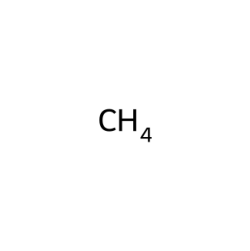

In [9]:
# methane
# Note how methane has a relatively high formation energy (compared to QM9)
# This correlates with lower thermodynamic stability and higher reactivity
# For example, methane readily burns in oxygen (CH₄ + 2O₂ → CO₂ + 2H₂O)
inspect_structure(0)

Atom │Number│    x     │    y     │    z     
─────┼──────┼──────────┼──────────┼──────────
  C  │  6   │     0.001│     1.414│    -0.022
  O  │  8   │     0.005│    -0.012│    -0.004
  C  │  6   │     0.597│    -0.616│    -1.043
  C  │  6   │     0.721│    -1.956│    -1.245
  O  │  8   │     1.395│    -2.119│    -2.433
  C  │  6   │     1.632│    -0.871│    -2.865
  N  │  7   │     1.186│     0.068│    -2.091
  H  │  1   │     1.020│     1.813│    -0.026
  H  │  1   │    -0.529│     1.798│    -0.899
  H  │  1   │    -0.516│     1.717│     0.890
  H  │  1   │     0.427│    -2.842│    -0.714
  H  │  1   │     2.160│    -0.766│    -3.800


SMILE: COc1cocn1


Formation Energy: -52.457
Formation Energy (normalized): 2.30117


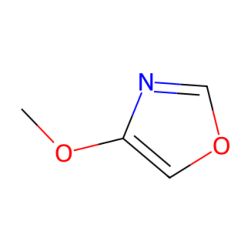

In [10]:
# random structure
inspect_structure(np.random.choice(range(len(smiles_data))))

## Task 1

In [11]:
# Task 1, Tokenize character by character

all_chars = [char for smile in smiles_data for char in smile] # Flattens chars
vocab = sorted(set(all_chars))
vocab = ['<PAD>', '<UNK>'] + vocab
token_to_idx = {token: idx for idx, token in enumerate(vocab)}

def smiles_to_sequence(smile):
    return [token_to_idx.get(char, token_to_idx['<UNK>']) for char in smile]

tokenized = [smiles_to_sequence(s) for s in smiles_data]
max_len = max(len(seq) for seq in tokenized)
padded = torch.nn.utils.rnn.pad_sequence(
    [torch.tensor(seq) for seq in tokenized],
    batch_first=True,
    padding_value=token_to_idx['<PAD>']
)
print(f"Vocab size: {len(vocab)}")
print(f"Max SMILES length: {max_len}")
print("Example (index 0):", padded[0])

Vocab size: 26
Max SMILES length: 62
Example (index 0): tensor([15,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0])


In [12]:
class SmilesDataset(Dataset):
  def __init__(self, smiles_tensor, energy_tensor, indicies):
    self.smiles_tensor = smiles_tensor[indicies]
    self.energy_tensor = energy_tensor[indicies]

  def __len__(self):
    return len(self.energy_tensor)

  def __getitem__(self, idx):
      return self.smiles_tensor[idx], self.energy_tensor[idx]

train_dataset = SmilesDataset(padded, fe_tensor, train_idxes)
val_dataset   = SmilesDataset(padded, fe_tensor, val_idxes)
test_dataset  = SmilesDataset(padded, fe_tensor, test_idxes)

BS = 128
train_loader = DataLoader(train_dataset, batch_size=BS, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BS)
test_loader = DataLoader(test_dataset, batch_size=BS)

print("Train batches:", len(train_loader))
print("Validation batches:", len(val_loader))
print("Test batches:", len(test_loader))

Train batches: 837
Validation batches: 93
Test batches: 79


In [13]:
class SMILESEnergyPredictor(nn.Module):
  def __init__(self, vocab_size, embed_dim=128, hidden_dim=256):
    super().__init__()
    self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=token_to_idx['<PAD>'])
    self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True)
    self.fc = nn.Linear(hidden_dim, 1)
  def forward(self, x):
    emb = self.embedding(x)
    output, (h_n, _) = self.lstm(emb)
    out = self.fc(h_n.squeeze(0))
    return out.squeeze(1)

In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SMILESEnergyPredictor(vocab_size=len(token_to_idx)).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

def train_smiles_model(model, train_loader, val_loader, epochs=10):
  best_val_loss = float('inf')
  for epoch in range(epochs):
    model.train()
    train_loss = 0
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", leave=False)
    for x_batch, y_batch in train_loader:
      x_batch = x_batch.to(device)
      y_batch = y_batch.to(device)

      optimizer.zero_grad()
      preds = model(x_batch)
      loss = criterion(preds, y_batch)
      loss.backward()
      optimizer.step()

      train_loss += loss.item() * x_batch.size(0)
      pbar.set_postfix(train_loss=loss.item())
    train_loss /= len(train_loader.dataset)

    # Val
    model.eval()
    val_loss = 0
    with torch.no_grad():
      for x_batch, y_batch in val_loader:
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)
        preds = model(x_batch)
        loss = criterion(preds, y_batch)
        val_loss += loss.item() * x_batch.size(0)
    val_loss /= len(val_loader.dataset)
    if val_loss < best_val_loss:
      best_val_loss = val_loss
      # torch.save(model.state_dict(), "/content/drive/MyDrive/ColabNotebooks/ass2/models/smiles_model.pth")
    print(f"Epoch {epoch+1:2d} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")





In [ ]:
train_smiles_model(model, train_loader, val_loader, epochs=20)

In [ ]:
# model = SMILESEnergyPredictor(vocab_size=len(token_to_idx)).to(device)
# model.load_state_dict(torch.load("/content/drive/MyDrive/ColabNotebooks/ass2/models/smiles_model.pth"))
model.eval()

# 2) Prepare loss functions
mse_loss = nn.MSELoss(reduction="mean")
mae_loss = nn.L1Loss(reduction="mean")

# 3) Loop over test set
all_preds = []
all_targets = []

with torch.no_grad():
    for x_batch, y_batch in test_loader:
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)
        preds = model(x_batch)

        all_preds.append(preds.cpu())
        all_targets.append(y_batch.cpu())

# 4) Concatenate
preds = torch.cat(all_preds)    # shape [N]
targets = torch.cat(all_targets)

# 5) Metrics in normalized space
mse_norm = mse_loss(preds, targets).item()
mae_norm = mae_loss(preds, targets).item()

print(f"Test (normalized) →  MSE: {mse_norm:.5f} | MAE: {mae_norm:.5f}")

# 6) Denormalize to actual formation energies
preds_actual   = preds * std + mu
targets_actual = targets * std + mu

mse_actual = mse_loss(preds_actual, targets_actual).item()
mae_actual = mae_loss(preds_actual, targets_actual).item()

print(f"Test (actual)     →  MSE: {mse_actual:.5f} | MAE: {mae_actual:.5f}")

In [15]:
# Geometric

max_atom = max(max(types) for types in type_data)
num_atom_types = max_atom + 1

def make_graph(i):
    pos = torch.tensor(pos_data[i], dtype=torch.float)
    atom_nums = torch.tensor(type_data[i], dtype=torch.long)
    y = fe_tensor[i].unsqueeze(0)

    return Data(z=atom_nums, pos=pos, y=y)



train_graphs = [make_graph(i) for i in train_idxes]
val_graphs   = [make_graph(i) for i in val_idxes]
test_graphs  = [make_graph(i) for i in test_idxes]


from torch_geometric.loader import DataLoader
train_loader = DataLoader(train_graphs, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_graphs,   batch_size=32)
test_loader  = DataLoader(test_graphs,  batch_size=32)

In [16]:
from torch_geometric.nn import NNConv, global_mean_pool, SchNet

class GeometricEnergyPredictor(nn.Module):
    def __init__(self, cutoff=5.0, hidden_channels=128,
                 num_filters=128, num_interactions=6,
                 num_gaussians=32):
        super().__init__()
        self.schnet = SchNet(hidden_channels=hidden_channels,
                             num_filters=num_filters,
                             num_interactions=num_interactions,
                             num_gaussians=num_gaussians,
                             cutoff=cutoff)
    def forward(self, data):
        # returns shape [batch_size, 1] or [batch_size]
        return self.schnet(data.z, data.pos, data.batch).squeeze(1)


In [23]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model_g = GeometricEnergyPredictor(
    cutoff=5.0, hidden_channels=128,
    num_filters=128, num_interactions=6,
    num_gaussians=32
).to(device)
criterion = nn.MSELoss()

def train_geometry_model(model, train_loader, val_loader, epochs=50, lr=1e-3):
    model = model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
    scheduler = ReduceLROnPlateau(optimizer, 'min', patience=5)
    best_val = float('inf')
    train_losses, val_losses = [], []

    for epoch in range(1, epochs+1):
        # --- TRAIN ---
        model.train()
        tot_train = 0
        for data in train_loader:
            data = data.to(device)
            optimizer.zero_grad()
            out = model(data)
            y   = data.y.view(-1)
            loss= criterion(out, y)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            tot_train += loss.item() * data.num_graphs
        avg_train = tot_train / len(train_loader.dataset)
        train_losses.append(avg_train)

        # --- VALID ---
        model.eval()
        tot_val = 0
        with torch.no_grad():
            for data in val_loader:
                data = data.to(device)
                out  = model(data)
                y    = data.y.view(-1)
                tot_val += criterion(out, y).item() * data.num_graphs
        avg_val = tot_val / len(val_loader.dataset)
        val_losses.append(avg_val)

        # LR sched & checkpoint
        scheduler.step(avg_val)
        if avg_val < best_val:
            best_val = avg_val
            # torch.save(model.state_dict(), "/content/drive/MyDrive/ColabNotebooks/ass2/models/geo_model.pth")

        print(f"Epoch {epoch} — Train: {avg_train:.4f} | Val: {avg_val:.4f}")

    # Plot losses
    import matplotlib.pyplot as plt
    plt.plot(train_losses, label='Train'); plt.plot(val_losses, label='Val')
    plt.legend(); plt.show()


cpu


In [ ]:
train_geometry_model(model_g, train_loader, val_loader, epochs=20)

In [ ]:
# model_g.load_state_dict(torch.load("geo_model.pth"))
# model_g.eval()

# accumulate
preds, targs = [], []
with torch.no_grad():
    for data in test_loader:
        data = data.to(device)
        out = model_g(data).cpu()
        preds.append(out)
        targs.append(data.y.cpu())

preds = torch.cat(preds)
targs = torch.cat(targs)

mse = criterion(preds, targs).item()
mae = nn.L1Loss()(preds, targs).item()
print(f"Geo Test (normalized) → MSE: {mse:.5f} | MAE: {mae:.5f}")

# denormalize
preds_act = preds * std + mu
targs_act = targs * std + mu
print(f"Geo Test (actual)     → MSE: {nn.MSELoss()(preds_act, targs_act):.5f} | MAE: {nn.L1Loss()(preds_act, targs_act):.5f}")

## Task 2

In [18]:
import random, torch, numpy as np, matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, r2_score

# reproducibility
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

In [ ]:
# SMILE MODEL

In [19]:
# sample the subset
def sample_subset_loader(full_idx, size, smiles_data, fe_tensor, token_to_idx, batch_size=64):
    subset_idx     = random.sample(list(full_idx), size)
    smiles_subset  = [smiles_data[i] for i in subset_idx]
    fe_subset      = fe_tensor[subset_idx]

    max_len = max(len(s) for s in smiles_subset)
    smiles_tensor = torch.zeros((size, max_len), dtype=torch.long)
    for i, seq in enumerate(smiles_subset):
        for j, tok in enumerate(seq):
            smiles_tensor[i, j] = token_to_idx.get(tok, 0)

    ds  = torch.utils.data.TensorDataset(smiles_tensor, fe_subset)
    dl  = torch.utils.data.DataLoader(ds, batch_size=batch_size, shuffle=True)
    return dl

@torch.no_grad()
def evaluate_smiles(model, test_loader, mu, std):
    model.eval()
    preds, targets = [], []
    for x, y in test_loader:
        x, y = x.to(device), y.to(device)
        preds.append(model(x).cpu())
        targets.append(y.cpu())
    preds   = torch.cat(preds)
    targets = torch.cat(targets)

    mu_t, std_t = torch.tensor(mu), torch.tensor(std)
    preds   = preds * std_t + mu_t
    targets = targets * std_t + mu_t
    return (mean_absolute_error(targets, preds), r2_score(targets, preds))

In [25]:
# Smiles dataset
train_dataset = SmilesDataset(padded, fe_tensor, train_idxes)
val_dataset   = SmilesDataset(padded, fe_tensor, val_idxes)
test_dataset  = SmilesDataset(padded, fe_tensor, test_idxes)

BS = 128
train_loader = DataLoader(train_dataset, batch_size=BS, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BS)
test_loader = DataLoader(test_dataset, batch_size=BS)

print("Train batches:", len(train_loader))
print("Validation batches:", len(val_loader))
print("Test batches:", len(test_loader))

Train batches: 837
Validation batches: 93
Test batches: 79


In [26]:
# Smile
subset_sizes = [100, 300, 1000, 3000, 10000]
smiles_res   = {"size": [], "mae": [], "r2": []}

for n in subset_sizes:
    print(f"\nSMILES - {n}")
    train_dl = sample_subset_loader(train_idxes, n, smiles_data, fe_tensor, token_to_idx)
    val_dl   = sample_subset_loader(val_idxes, min(len(val_idxes), 1000), smiles_data, fe_tensor, token_to_idx)

    model_s = SMILESEnergyPredictor(vocab_size=len(token_to_idx)).to(device)
    train_smiles_model(model_s, train_dl, val_dl, epochs=10)

    mae, r2 = evaluate_smiles(model_s, test_loader, mu, std)
    smiles_res["size"].append(n); smiles_res["mae"].append(mae); smiles_res["r2"].append(r2)
    print(f"→ MAE={mae:.3f} | R-SQUARED={r2:.3f}")


SMILES - 100


Epoch 1/10:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch  1 | Train Loss: 1.1048 | Val Loss: 0.9858


Epoch 2/10:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch  2 | Train Loss: 1.1048 | Val Loss: 0.9858


Epoch 3/10:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch  3 | Train Loss: 1.1048 | Val Loss: 0.9858


Epoch 4/10:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch  4 | Train Loss: 1.1048 | Val Loss: 0.9858


Epoch 5/10:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch  5 | Train Loss: 1.1048 | Val Loss: 0.9858


Epoch 6/10:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch  6 | Train Loss: 1.1048 | Val Loss: 0.9858


Epoch 7/10:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch  7 | Train Loss: 1.1048 | Val Loss: 0.9858


Epoch 8/10:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch  8 | Train Loss: 1.1048 | Val Loss: 0.9858


Epoch 9/10:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch  9 | Train Loss: 1.1048 | Val Loss: 0.9858


Epoch 10/10:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 10 | Train Loss: 1.1048 | Val Loss: 0.9858
→ MAE=8.144 | R-SQUARED=-0.001

SMILES - 300


Epoch 1/10:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch  1 | Train Loss: 1.0779 | Val Loss: 0.9680


Epoch 2/10:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch  2 | Train Loss: 1.0779 | Val Loss: 0.9680


Epoch 3/10:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch  3 | Train Loss: 1.0779 | Val Loss: 0.9680


Epoch 4/10:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch  4 | Train Loss: 1.0779 | Val Loss: 0.9680


Epoch 5/10:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch  5 | Train Loss: 1.0779 | Val Loss: 0.9680


Epoch 6/10:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch  6 | Train Loss: 1.0779 | Val Loss: 0.9680


Epoch 7/10:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch  7 | Train Loss: 1.0779 | Val Loss: 0.9680


Epoch 8/10:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch  8 | Train Loss: 1.0779 | Val Loss: 0.9680


Epoch 9/10:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch  9 | Train Loss: 1.0779 | Val Loss: 0.9680


Epoch 10/10:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 10 | Train Loss: 1.0779 | Val Loss: 0.9680
→ MAE=8.153 | R-SQUARED=-0.002

SMILES - 1000


Epoch 1/10:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch  1 | Train Loss: 0.9318 | Val Loss: 1.0141


Epoch 2/10:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch  2 | Train Loss: 0.9318 | Val Loss: 1.0141


Epoch 3/10:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch  3 | Train Loss: 0.9318 | Val Loss: 1.0141


Epoch 4/10:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch  4 | Train Loss: 0.9318 | Val Loss: 1.0141


Epoch 5/10:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch  5 | Train Loss: 0.9318 | Val Loss: 1.0141


Epoch 6/10:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch  6 | Train Loss: 0.9318 | Val Loss: 1.0141


Epoch 7/10:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch  7 | Train Loss: 0.9318 | Val Loss: 1.0141


Epoch 8/10:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch  8 | Train Loss: 0.9318 | Val Loss: 1.0141


Epoch 9/10:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch  9 | Train Loss: 0.9318 | Val Loss: 1.0141


Epoch 10/10:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 10 | Train Loss: 0.9318 | Val Loss: 1.0141
→ MAE=8.134 | R-SQUARED=-0.001

SMILES - 3000


Epoch 1/10:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch  1 | Train Loss: 0.9970 | Val Loss: 0.9454


Epoch 2/10:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch  2 | Train Loss: 0.9970 | Val Loss: 0.9454


Epoch 3/10:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch  3 | Train Loss: 0.9970 | Val Loss: 0.9454


Epoch 4/10:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch  4 | Train Loss: 0.9970 | Val Loss: 0.9454


Epoch 5/10:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch  5 | Train Loss: 0.9970 | Val Loss: 0.9454


Epoch 6/10:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch  6 | Train Loss: 0.9970 | Val Loss: 0.9454


Epoch 7/10:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch  7 | Train Loss: 0.9970 | Val Loss: 0.9454


Epoch 8/10:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch  8 | Train Loss: 0.9970 | Val Loss: 0.9454


Epoch 9/10:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch  9 | Train Loss: 0.9970 | Val Loss: 0.9454


Epoch 10/10:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 10 | Train Loss: 0.9970 | Val Loss: 0.9454
→ MAE=8.140 | R-SQUARED=-0.000

SMILES - 10000


Epoch 1/10:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch  1 | Train Loss: 1.0105 | Val Loss: 1.0862


Epoch 2/10:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch  2 | Train Loss: 1.0105 | Val Loss: 1.0862


Epoch 3/10:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch  3 | Train Loss: 1.0105 | Val Loss: 1.0862


Epoch 4/10:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch  4 | Train Loss: 1.0105 | Val Loss: 1.0862


Epoch 5/10:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch  5 | Train Loss: 1.0105 | Val Loss: 1.0862


Epoch 6/10:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch  6 | Train Loss: 1.0105 | Val Loss: 1.0862


Epoch 7/10:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch  7 | Train Loss: 1.0105 | Val Loss: 1.0862


Epoch 8/10:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch  8 | Train Loss: 1.0105 | Val Loss: 1.0862


Epoch 9/10:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch  9 | Train Loss: 1.0105 | Val Loss: 1.0862


Epoch 10/10:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 10 | Train Loss: 1.0105 | Val Loss: 1.0863
→ MAE=8.144 | R-SQUARED=-0.004


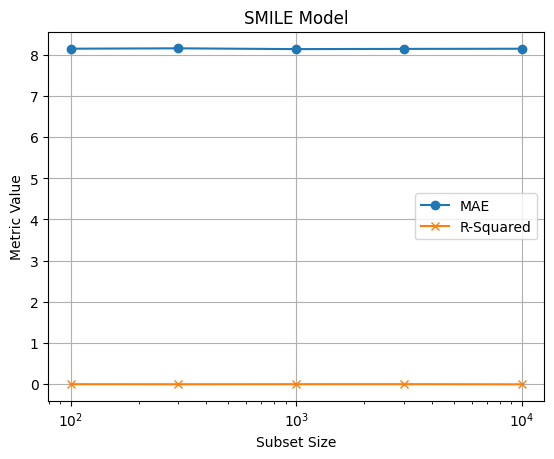

In [27]:
plt.figure()
plt.plot(smiles_res["size"], smiles_res["mae"], marker='o',  label="MAE")
plt.plot(smiles_res["size"], smiles_res["r2"],  marker='x',  label="R-Squared")
plt.xscale("log"); plt.xlabel("Subset Size")
plt.ylabel("Metric Value"); plt.title("SMILE Model")
plt.grid(True); plt.legend(); plt.show()


In [ ]:
# GEOMETRY MODEL

In [28]:
import random, torch, numpy as np, matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, r2_score
from torch_geometric.loader import DataLoader

random.seed(42); np.random.seed(42); torch.manual_seed(42)

In [29]:
def build_subset_graphs(indices):
    return [make_graph(i) for i in indices]

def get_graph_loader(graphs, batch=32, shuffle=True):
    return DataLoader(graphs, batch_size=batch, shuffle=shuffle)

@torch.no_grad()
def evaluate_geo(model, loader, mu, std):
    model.eval()
    preds, targets = [], []
    for data in loader:
        data = data.to(device)
        preds.append(model(data).cpu())
        targets.append(data.y.view(-1).cpu())
    preds   = torch.cat(preds)
    targets = torch.cat(targets)

    mu_t, std_t = torch.tensor(mu), torch.tensor(std)
    preds   = preds * std_t + mu_t
    targets = targets * std_t + mu_t
    return (mean_absolute_error(targets, preds),r2_score(targets, preds))

In [30]:
# Geometry dataset
train_graphs = [make_graph(i) for i in train_idxes]
val_graphs   = [make_graph(i) for i in val_idxes]
test_graphs  = [make_graph(i) for i in test_idxes]


from torch_geometric.loader import DataLoader
train_loader = DataLoader(train_graphs, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_graphs,   batch_size=32)
test_loader  = DataLoader(test_graphs,  batch_size=32)


Geo - 100
Epoch 1 — Train: 262.3925 | Val: 57.6244
Epoch 2 — Train: 69.5674 | Val: 18.5162
Epoch 3 — Train: 31.7271 | Val: 1.4547
Epoch 4 — Train: 3.0828 | Val: 1.6320
Epoch 5 — Train: 1.9064 | Val: 1.4079
Epoch 6 — Train: 2.7774 | Val: 0.5880
Epoch 7 — Train: 0.4808 | Val: 0.4882
Epoch 8 — Train: 0.3168 | Val: 0.3467
Epoch 9 — Train: 0.3836 | Val: 2.4671
Epoch 10 — Train: 1.3834 | Val: 2.2543


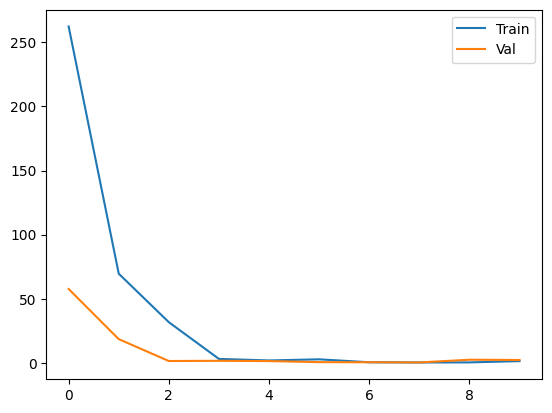

→ MAE=13.645 | R-SQUARED=-1.253

Geo - 300
Epoch 1 — Train: 140.5432 | Val: 8.4501
Epoch 2 — Train: 5.5870 | Val: 2.1024
Epoch 3 — Train: 2.1619 | Val: 7.5853
Epoch 4 — Train: 3.9851 | Val: 1.2542
Epoch 5 — Train: 2.4181 | Val: 2.0102
Epoch 6 — Train: 2.2499 | Val: 2.1112
Epoch 7 — Train: 2.1049 | Val: 3.8259
Epoch 8 — Train: 1.9692 | Val: 0.4552
Epoch 9 — Train: 1.6138 | Val: 0.9669
Epoch 10 — Train: 1.6281 | Val: 1.6871


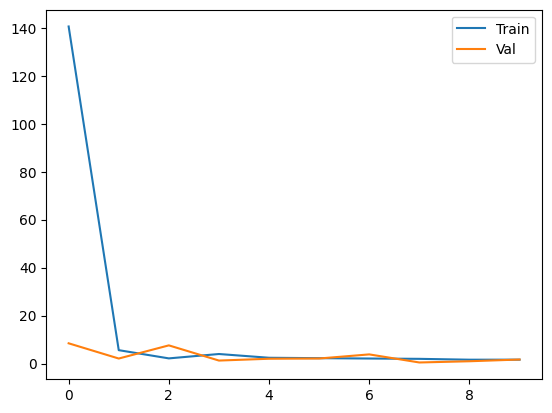

→ MAE=12.153 | R-SQUARED=-0.664

Geo - 1000
Epoch 1 — Train: 42.1213 | Val: 1.7050
Epoch 2 — Train: 1.9213 | Val: 2.7294
Epoch 3 — Train: 0.9134 | Val: 0.3143
Epoch 4 — Train: 0.6371 | Val: 0.9480
Epoch 5 — Train: 0.5231 | Val: 0.4817
Epoch 6 — Train: 0.4631 | Val: 0.2908
Epoch 7 — Train: 0.5526 | Val: 1.9538
Epoch 8 — Train: 1.0208 | Val: 0.2891
Epoch 9 — Train: 0.7755 | Val: 0.3277
Epoch 10 — Train: 0.6400 | Val: 0.2534


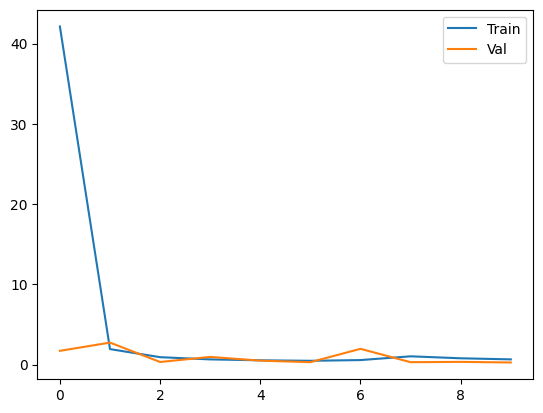

→ MAE=3.313 | R-SQUARED=0.746

Geo - 3000
Epoch 1 — Train: 13.5260 | Val: 0.5629
Epoch 2 — Train: 1.8098 | Val: 1.0735
Epoch 3 — Train: 0.6551 | Val: 0.6864
Epoch 4 — Train: 0.3176 | Val: 0.5159
Epoch 5 — Train: 0.3575 | Val: 0.2639
Epoch 6 — Train: 0.2748 | Val: 0.1775
Epoch 7 — Train: 0.2050 | Val: 0.2934
Epoch 8 — Train: 0.1968 | Val: 0.2596
Epoch 9 — Train: 0.1840 | Val: 0.1452
Epoch 10 — Train: 0.1966 | Val: 0.1478


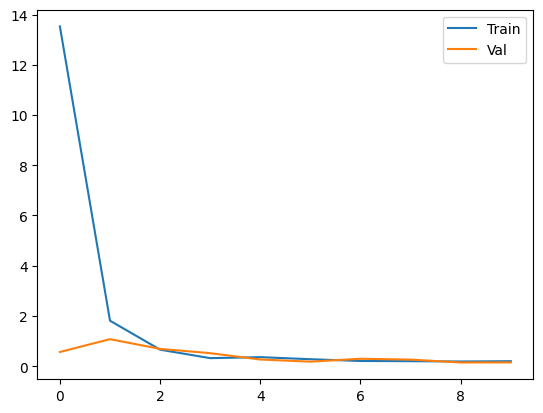

→ MAE=2.933 | R-SQUARED=0.858

Geo - 10000
Epoch 1 — Train: 6.9105 | Val: 1.4242
Epoch 2 — Train: 0.5686 | Val: 0.3169
Epoch 3 — Train: 0.3065 | Val: 0.1872
Epoch 4 — Train: 0.1976 | Val: 0.2911
Epoch 5 — Train: 0.1159 | Val: 0.1234
Epoch 6 — Train: 0.0937 | Val: 0.0703
Epoch 7 — Train: 0.0617 | Val: 0.0413
Epoch 8 — Train: 0.0552 | Val: 0.0500
Epoch 9 — Train: 0.0501 | Val: 0.0346
Epoch 10 — Train: 0.0573 | Val: 0.0446


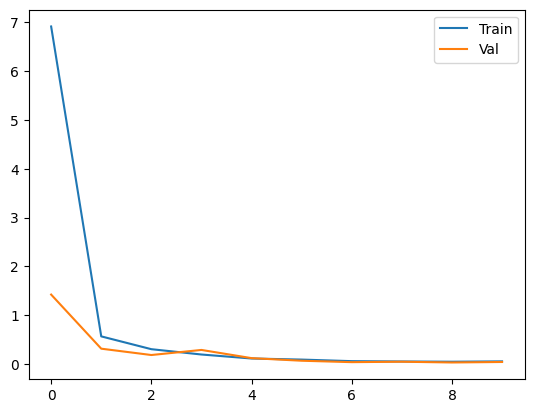

→ MAE=1.590 | R-SQUARED=0.968


In [33]:
subset_sizes = [100, 300, 1000, 3000, 10000]
geo_res      = {"size": [], "mae": [], "r2": []}

for n in subset_sizes:
    print(f"\nGeo - {n}")
    train_idx  = random.sample(list(train_idxes), n)
    train_dl   = get_graph_loader(build_subset_graphs(train_idx))
    model_g = GeometricEnergyPredictor().to(device)
    train_geometry_model(model_g, train_dl, val_loader, epochs=10, lr=1e-3)

    mae, r2 = evaluate_geo(model_g, test_loader, mu, std)
    geo_res["size"].append(n); geo_res["mae"].append(mae); geo_res["r2"].append(r2)
    print(f"→ MAE={mae:.3f} | R-SQUARED={r2:.3f}")

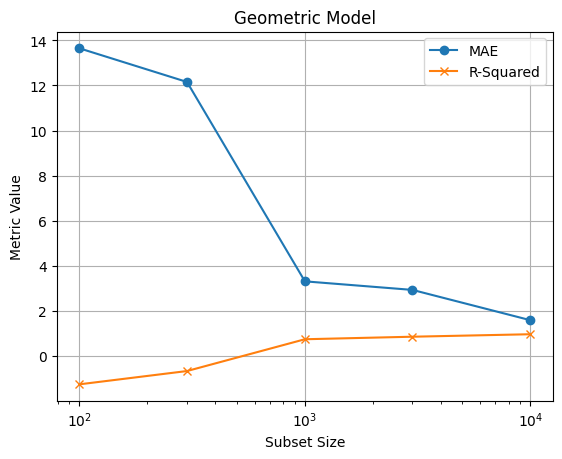

In [34]:
plt.figure()
plt.plot(geo_res["size"], geo_res["mae"], marker='o',  label="MAE")
plt.plot(geo_res["size"], geo_res["r2"],  marker='x',  label="R-Squared")
plt.xscale("log"); plt.xlabel("Subset Size")
plt.ylabel("Metric Value"); plt.title("Geometric Model")
plt.grid(True); plt.legend(); plt.show()

## Task 3

In [ ]:
def is_valid_smiles(smiles):
    if smiles is None:
        return False
    try:
        mol = Chem.MolFromSmiles(smiles)
        return mol is not None
    except:
        return False

def canonicalize(smiles):
    try:
        mol = Chem.MolFromSmiles(smiles)
        if mol:
            return Chem.MolToSmiles(mol, canonical=True)
        return 'None'
    except:
        return 'None'

In [ ]:
canonicalize("COO"), canonicalize("O(C)O")

In [ ]:
is_valid_smiles("COO"), is_valid_smiles("O(C)O"), is_valid_smiles("C##")